Завдання: знайти, побудувати нейромережу (знайти датасети та провести тренування), яка 
дозволяє здійснювати виявлення та ідентифікацію (задача класифікації) аудіо 
мотоцикла/квадроцикла. Оцінити результат роботи шляхом порівняння показників 
декількох варіантів нейромережі.

Імпорт бібліотек , завантаження моделі YAMNet та створення функції зчитування Wav файлів.

In [3]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import scipy.signal
import soundfile as sf
from IPython.display import Audio, display


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [4]:
import tensorflow_hub as hub

yamnet_model = hub.load('D:\YAMNet1\model\chive')
print("Модель YAMNet успішно завантажена!")


<>:3: SyntaxWarning: invalid escape sequence '\Y'
<>:3: SyntaxWarning: invalid escape sequence '\Y'
C:\Users\Admin\AppData\Local\Temp\ipykernel_2964\51949069.py:3: SyntaxWarning: invalid escape sequence '\Y'
  yamnet_model = hub.load('D:\YAMNet1\model\chive')




Модель YAMNet успішно завантажена!


In [5]:
#Зчитування WAV файлів та переведення його в зручну модель
def load_wav_16k_mono(filename):
    """Завантажити WAV-файл, перевести в моно та 16 кГц."""
    wav, sample_rate = sf.read(filename)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if sample_rate != 16000:
        num_samples = int(len(wav) * 16000 / sample_rate)
        wav = scipy.signal.resample(wav, num_samples)
    return tf.convert_to_tensor(wav, dtype=tf.float32)

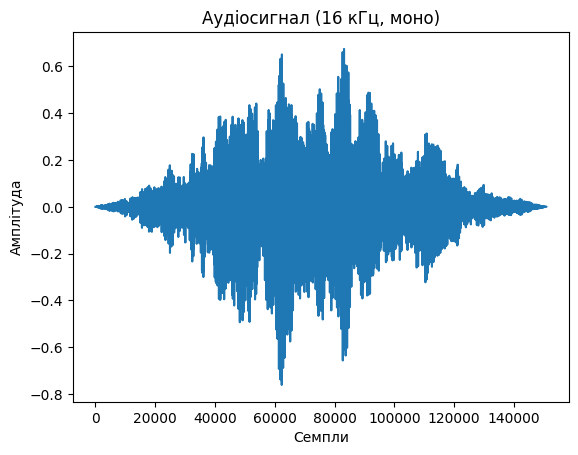

In [6]:
#Шлях до тестового файлу
filename = "D:/YAMNet1/data/sample_moto.wav"

# Завантаження даних
testing_wav_data = load_wav_16k_mono(filename)

# Візуалізація сигналу
plt.plot(testing_wav_data.numpy())
plt.title("Аудіосигнал (16 кГц, моно)")
plt.xlabel("Семпли")
plt.ylabel("Амплітуда")
plt.show()

# Програвання аудіо
display(Audio(data=testing_wav_data.numpy(), rate=16000))

In [7]:
#Список класів у моделі
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [8]:
#Перевіряємо тестовий звук
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Vehicle
The embeddings shape: (19, 1024)


Модель правильно визначила, що звук видала техніка. Тепер необхідно більш спеціалізовано навчити модель на розпізнавання мотоциклів/квадроциклів. 
Для початку, завантажимо дані та напишемо функцію витягування ембедингів.

In [9]:
#Завантажуємо датасет з потрібними нам даними.
DATA_DIR = {
    "motorcycle": "D:\YAMNet1\data\motorcycle",
    "background": "D:\YAMNet1\data\background"
}
print(DATA_DIR)

{'motorcycle': 'D:\\YAMNet1\\data\\motorcycle', 'background': 'D:\\YAMNet1\\data\x08ackground'}


<>:3: SyntaxWarning: invalid escape sequence '\Y'
<>:4: SyntaxWarning: invalid escape sequence '\Y'
<>:3: SyntaxWarning: invalid escape sequence '\Y'
<>:4: SyntaxWarning: invalid escape sequence '\Y'
C:\Users\Admin\AppData\Local\Temp\ipykernel_2964\3636487337.py:3: SyntaxWarning: invalid escape sequence '\Y'
  "motorcycle": "D:\YAMNet1\data\motorcycle",
C:\Users\Admin\AppData\Local\Temp\ipykernel_2964\3636487337.py:4: SyntaxWarning: invalid escape sequence '\Y'
  "background": "D:\YAMNet1\data\background"


In [10]:
#Функція для отримання ембеддінгів з сегментованих аудіофайлів
def extract_embeddings_segmented(base_dir, yamnet_model, max_files_per_class=None, segment_duration=0.96, target_rate=16000):
    dataset = []
    class_map = {
        "motorcycle": 1,
        "background": 0
    }
    samples_per_segment = int(segment_duration * target_rate)

    for class_name, label in class_map.items():
        folder_path = os.path.join(base_dir, class_name)
        wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
        if max_files_per_class:
            wav_files = wav_files[:max_files_per_class]

        for fname in wav_files:
            file_path = os.path.join(folder_path, fname)
            try:
                wav = load_wav_16k_mono(file_path).numpy()
                total_samples = len(wav)

                #Розбиваємо на фрагменти по 0.96 с, з якими зручно працювати YAMNet
                for start in range(0, total_samples - samples_per_segment + 1, samples_per_segment):
                    segment = wav[start:start + samples_per_segment]
                    segment_tensor = tf.convert_to_tensor(segment, dtype=tf.float32)
                    _, embeddings, _ = yamnet_model(segment_tensor)
                    mean_embedding = tf.reduce_mean(embeddings, axis=0)
                    dataset.append((mean_embedding.numpy(), label))

            except Exception as e:
                print(f"Помилка з {file_path}: {e}")

    return dataset



In [11]:
dataset = extract_embeddings_segmented("D:/YAMNet1/data", yamnet_model)  


#Розділимо features і labels
X = np.array([x for x, _ in dataset])
y = np.array([y for _, y in dataset])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (5140, 1024)
y shape: (5140,)


Знайдемо найкращий класифікатор. Протестуємо Logistic Regression, Random Forest, CNN

Logistic Regression Evaluation
Accuracy:  0.949
Precision: 0.945
Recall:    0.959
F1 Score:  0.952
AUC:       0.988

Classification Report:
              precision    recall  f1-score   support

  background       0.95      0.94      0.95       493
  motorcycle       0.94      0.96      0.95       535

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



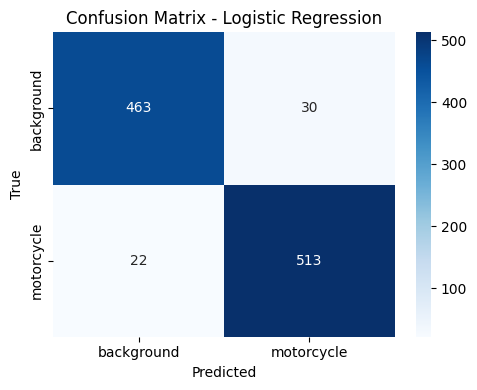

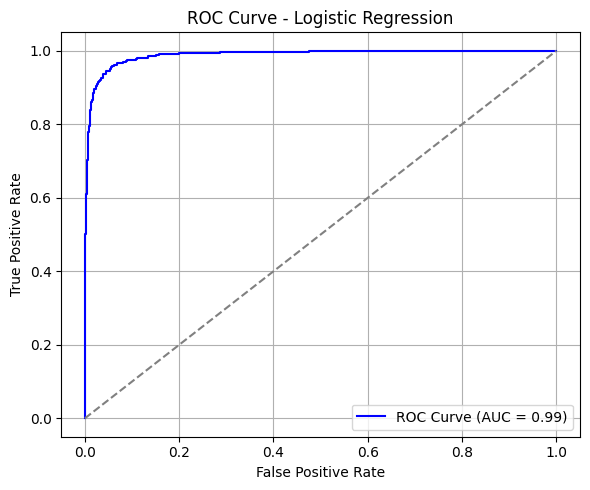

In [12]:
#1.LNN
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

#Розділення на навчальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Ініціалізація і тренування логістичної регресії
clf_lr = LogisticRegression(max_iter=1000, solver='liblinear')  # liblinear добре працює для малих датасетів
clf_lr.fit(X_train, y_train)

#Передбачення
y_pred = clf_lr.predict(X_test)
y_proba = clf_lr.predict_proba(X_test)[:, 1]

#Метрики класифікації
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

#Виведення результатів
print("Logistic Regression Evaluation")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC:       {roc_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["background", "motorcycle"]))

#Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=["background", "motorcycle"], yticklabels=["background", "motorcycle"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#ROC-крива
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


Random Forest Evaluation
Accuracy:  0.940
Precision: 0.950
Recall:    0.933
F1 Score:  0.942
AUC:       0.988

Classification Report:
              precision    recall  f1-score   support

  background       0.93      0.95      0.94       493
  motorcycle       0.95      0.93      0.94       535

    accuracy                           0.94      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.94      0.94      0.94      1028



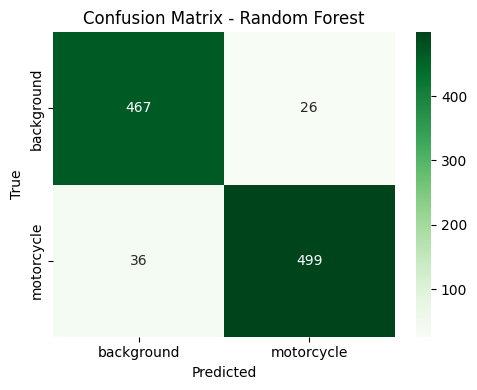

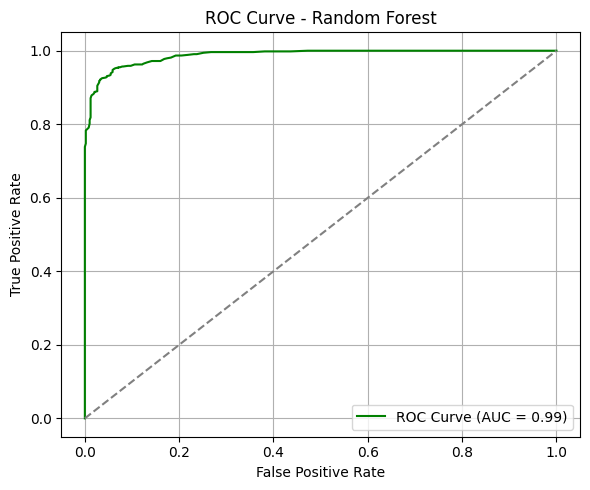

In [13]:
#2.Random Forest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

#Розділення вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Створення і тренування Random Forest
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,           
    random_state=42,
    n_jobs=-1                 # Використання всіх ядер CPU
)
clf_rf.fit(X_train, y_train)

#Передбачення
y_pred = clf_rf.predict(X_test)
y_proba = clf_rf.predict_proba(X_test)[:, 1]

#Метрики
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

#Виведення результатів
print("Random Forest Evaluation")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"AUC:       {roc_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["background", "motorcycle"]))

#Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Greens",
            xticklabels=["background", "motorcycle"],
            yticklabels=["background", "motorcycle"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#ROC-крива
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [14]:
#3 CNN
import numpy as np
from sklearn.model_selection import train_test_split

X_cnn = X.copy()
y_cnn = y.copy()

#Перетворюємо форму (n_samples, 1024) до (n_samples, 1024, 1) для Conv1D
X_cnn = X_cnn[..., np.newaxis]

#Розділення
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)


In [15]:
#Навчаємо модель CNN
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=(1024, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1020, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 510, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 508, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 254, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,040,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,046,913 (3.99 MB)

 Trainable params: 1,046,913 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8586 - loss: 0.3409 - val_accuracy: 0.9356 - val_loss: 0.2142
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9264 - loss: 0.2003 - val_accuracy: 0.9465 - val_loss: 0.1512
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9397 - loss: 0.1520 - val_accuracy: 0.9550 - val_loss: 0.1366
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9515 - loss: 0.1218 - val_accuracy: 0.9526 - val_loss: 0.1456
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9498 - loss: 0.1344 - val_accuracy: 0.9563 - val_loss: 0.1569
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9595 - loss: 0.1080 - val_accuracy: 0.9599 - val_loss: 0.1146
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9622 - loss: 0.0964 - val_accuracy: 0.9563 - val_loss: 0.1243
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9668 - loss: 0.0895 - val_accu

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Confusion Matrix:
[[470  28]
 [ 21 509]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       498
           1       0.95      0.96      0.95       530

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



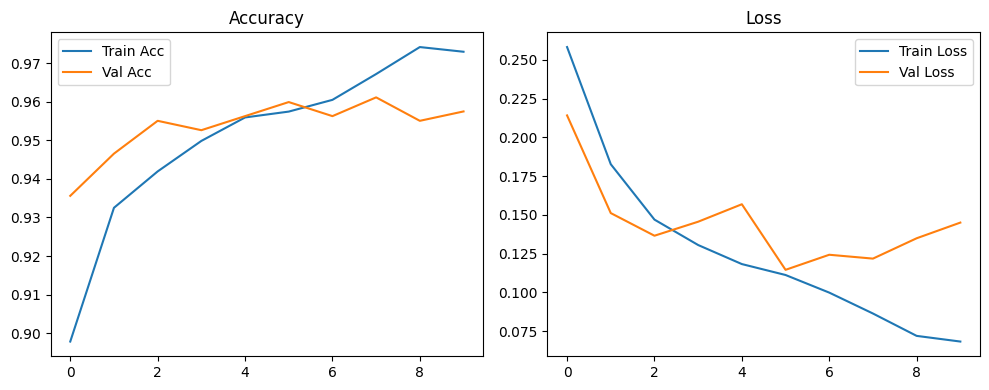

In [16]:
#Оцінюємо модель
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#Прогноз
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

#Метрики
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Графік тренування
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import numpy as np

#Прогноз імовірностей
y_pred_prob = model.predict(X_test).flatten()

# Прогноз класів (поріг 0.5)
y_pred = (y_pred_prob > 0.5).astype("int32")

#Метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

#Вивід числових значень
print("CNN Evaluation")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
CNN Evaluation
Accuracy:  0.9523
Precision: 0.9479
Recall:    0.9604
F1 Score:  0.9541
AUC:       0.9919

Confusion Matrix:
[[470  28]
 [ 21 509]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       498
           1       0.95      0.96      0.95       530

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



In [18]:
#Виведемо загальні оцінки моделей
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)
import pandas as pd
import numpy as np

def compare_classifiers_simple(models_dict, cnn_model, X_test, y_test):
    results = []
    
    #Перевіряємо, чи потрібно перетворити X_test
    X_test_2d = X_test.reshape(X_test.shape[0], -1)          # для sklearn
    X_test_3d = X_test.reshape(X_test.shape[0], 1024, 1)     # для CNN

    #Обробка sklearn моделей
    for name, model in models_dict.items():
        y_pred = model.predict(X_test_2d)
        y_proba = model.predict_proba(X_test_2d)[:, 1]

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "AUC": roc_auc_score(y_test, y_proba)
        })

    #Обробка CNN
    y_cnn_proba = cnn_model.predict(X_test_3d).flatten()
    y_cnn_pred = (y_cnn_proba > 0.5).astype("int32")

    results.append({
        "Model": "CNN (Keras)",
        "Accuracy": accuracy_score(y_test, y_cnn_pred),
        "Precision": precision_score(y_test, y_cnn_pred),
        "Recall": recall_score(y_test, y_cnn_pred),
        "F1 Score": f1_score(y_test, y_cnn_pred),
        "AUC": roc_auc_score(y_test, y_cnn_proba)
    })

    #Формування таблиці
    results_df = pd.DataFrame(results)
    return results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)


In [19]:
#Порівняємо ефективність моделей
models_dict = {
    "Logistic Regression": clf_lr,
    "Random Forest": clf_rf
}

results_comparison = compare_classifiers_simple(models_dict, cnn_model=model, X_test=X_test, y_test=y_test)
print(results_comparison)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0        Random Forest  0.995136   0.992495  0.998113  0.995296  0.999879
1  Logistic Regression  0.968872   0.964552  0.975472  0.969981  0.995866
2          CNN (Keras)  0.952335   0.947858  0.960377  0.954077  0.991941


In [20]:
import joblib
joblib.dump(clf_rf, "model_rf.pkl")


['model_rf.pkl']

Як можемо побачити, найкраще впорався random forest, тому надалі використовуватимемо саме його.

Можемо потестувати роботу на кастомних аудіофайлах.

In [ ]:
from collections import Counter
import numpy as np
import tensorflow as tf

def predict_sound_segmented_rf(file_path, yamnet_model, rf_model, class_names={0: "background", 1: "motorcycle"}):
    try:
        #Завантажити та обробити аудіо
        wav = load_wav_16k_mono(file_path).numpy()
        segment_duration = 0.96
        sample_rate = 16000
        samples_per_segment = int(segment_duration * sample_rate)

        predictions = []
        probabilities = []

        total_samples = len(wav)
        num_segments = 0

        print(f"\nАналіз звуку: {file_path}")
        print(f"Розбивка на фрагменти по {segment_duration:.2f} секунд:")

        for start in range(0, total_samples - samples_per_segment + 1, samples_per_segment):
            segment = wav[start:start + samples_per_segment]
            segment_tensor = tf.convert_to_tensor(segment, dtype=tf.float32)

            #Отримуємо ембедінги з YAMNet
            _, embeddings, _ = yamnet_model(segment_tensor)
            mean_embedding = tf.reduce_mean(embeddings, axis=0).numpy().reshape(1, -1)  # (1, 1024)

            #Класифікація Random Forest
            pred_class = rf_model.predict(mean_embedding)[0]
            prob = rf_model.predict_proba(mean_embedding)[0][pred_class]

            predictions.append(pred_class)
            probabilities.append(prob)
            num_segments += 1

            print(f"Фрагмент {num_segments}: {class_names[pred_class]} (ймовірність: {prob:.2f})")

        #Загальний висновок
        if predictions:
            most_common_class = Counter(predictions).most_common(1)[0][0]
            avg_prob = np.mean(probabilities)
            print("\nСередній висновок:")
            print(f"Клас: {class_names[most_common_class]}")
            print(f"Середня ймовірність: {avg_prob:.2f}")
        else:
            print("Недостатньо даних для аналізу.")

    except Exception as e:
        print(f"Помилка при обробці {file_path}: {e}")


In [ ]:
predict_sound_segmented_rf("D:/YAMNet1/data/sample_moto.wav", yamnet_model, clf_rf)



Аналіз звуку: D:/YAMNet1/data/sample_moto.wav
Розбивка на фрагменти по 0.96 секунд:
Фрагмент 1: motorcycle (ймовірність: 0.75)
Фрагмент 2: motorcycle (ймовірність: 0.81)
Фрагмент 3: motorcycle (ймовірність: 0.89)
Фрагмент 4: motorcycle (ймовірність: 0.97)
Фрагмент 5: motorcycle (ймовірність: 0.95)
Фрагмент 6: motorcycle (ймовірність: 0.93)
Фрагмент 7: motorcycle (ймовірність: 0.97)
Фрагмент 8: motorcycle (ймовірність: 0.62)
Фрагмент 9: motorcycle (ймовірність: 0.87)

Середній висновок:
Клас: motorcycle
Середня ймовірність: 0.86


In [ ]:
predict_sound_segmented_rf("D:/YAMNet1/data/sample_ambient.wav", yamnet_model, clf_rf)


Аналіз звуку: D:/YAMNet1/data/sample_ambient.wav
Розбивка на фрагменти по 0.96 секунд:
Фрагмент 1: background (ймовірність: 0.73)
Фрагмент 2: background (ймовірність: 0.94)
Фрагмент 3: background (ймовірність: 0.89)
Фрагмент 4: background (ймовірність: 0.96)
Фрагмент 5: background (ймовірність: 0.60)

Середній висновок:
Клас: background
Середня ймовірність: 0.82


Тепер додамо функцію введення данних з мікрофону, для тестування звуків в реальному часі.

In [ ]:
import sounddevice as sd
import queue
import numpy as np
import tensorflow as tf

def predict_realtime_rf(
    yamnet_model,
    rf_model,
    class_names={0: "background", 1: "motorcycle"},
    segment_duration=0.96
):
    sample_rate = 16000
    segment_samples = int(segment_duration * sample_rate)

    q = queue.Queue()

    def audio_callback(indata, frames, time_info, status):
        if status:
            print(f"{status}")
        q.put(indata.copy())

    print("Слухаємо звук з мікрофону...)")

    try:
        with sd.InputStream(
            samplerate=sample_rate,
            channels=1,
            dtype='float32',
            blocksize=segment_samples,
            callback=audio_callback
        ):
            while True:
                audio_chunk = q.get()
                wav = np.squeeze(audio_chunk)
                if wav.ndim != 1:
                    wav = wav[:, 0]

                #Підготовка тензора
                segment_tensor = tf.convert_to_tensor(wav, dtype=tf.float32)

                #Ембедінги з YAMNet
                _, embeddings, _ = yamnet_model(segment_tensor)
                mean_embedding = tf.reduce_mean(embeddings, axis=0).numpy().reshape(1, -1)

                #Прогноз Random Forest
                pred_class = rf_model.predict(mean_embedding)[0]
                prob = rf_model.predict_proba(mean_embedding)[0][pred_class]

                print(f"{class_names[pred_class]} (ймовірність: {prob:.2f})")

    except KeyboardInterrupt:
        print("\nПрослуховування завершено користувачем.")
    


In [ ]:
predict_realtime_rf(yamnet_model, clf_rf)


Слухаємо звук з мікрофону...)
background (ймовірність: 0.84)
background (ймовірність: 0.83)
background (ймовірність: 0.83)
background (ймовірність: 0.78)
background (ймовірність: 0.80)
background (ймовірність: 0.77)
background (ймовірність: 0.86)
background (ймовірність: 0.75)
background (ймовірність: 0.82)
background (ймовірність: 0.85)
background (ймовірність: 0.80)
background (ймовірність: 0.82)
background (ймовірність: 0.87)
background (ймовірність: 0.88)
background (ймовірність: 0.75)
background (ймовірність: 0.84)
background (ймовірність: 0.80)
background (ймовірність: 0.86)
background (ймовірність: 0.83)
background (ймовірність: 0.79)
background (ймовірність: 0.80)
background (ймовірність: 0.86)
background (ймовірність: 0.85)
background (ймовірність: 0.79)
background (ймовірність: 0.77)
background (ймовірність: 0.81)
background (ймовірність: 0.80)
background (ймовірність: 0.78)
background (ймовірність: 0.76)
background (ймовірність: 0.81)
background (ймовірність: 0.78)
backgroun